In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [35]:
def plot_phase_portrait(f, ax=None, figsize=(3, 3)):
    xs = np.linspace(-2, 2, 11)
    us = np.linspace(-2, 2, 11)

    xss, uss = np.meshgrid(xs, us)
    dxss = f(xss, uss)

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()
    ax.quiver(xss, uss, dxss, 0)
    ax.set_xlabel("State $x$")
    ax.set_ylabel("Input $u$")

    return fig, ax

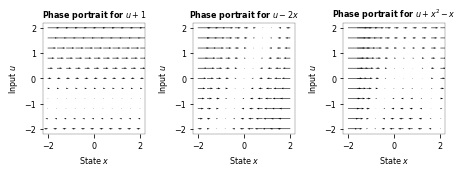

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(6.5, 2.5))

_, ax = plot_phase_portrait(lambda x, u: u + 1, axs[0])
ax.set_title('Phase portrait for $u + 1$')

_, ax = plot_phase_portrait(lambda x, u: u - 2 * x, axs[1])
ax.set_title('Phase portrait for $u - 2x$')

_, ax = plot_phase_portrait(lambda x, u: u + x ** 2 - x, axs[2])
ax.set_title('Phase portrait for $u + x^2 - x$')

fig.tight_layout()
fig.savefig('../phase_portraits.pdf', transparent=True, bbox_inches='tight')